In [39]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Part 1 - Two IBM devices, properties, and comparison

In [4]:
# Part I: IBM devices, properties, and comparison

# ----------------------------
# Config
# ----------------------------
DEVICE_A_NAME = None
DEVICE_B_NAME = None
MIN_QUBITS = 20

service = QiskitRuntimeService()

backends = service.backends()

def is_hardware_backend(b):
    try:
        return (not b.configuration().simulator) and b.status().operational
    except Exception:
        return False

candidates = [b for b in backends if is_hardware_backend(b)]
if MIN_QUBITS is not None:
    candidates = sorted(candidates, key=lambda b: -b.configuration().num_qubits)

def pick_two_devices():
    if DEVICE_A_NAME and DEVICE_B_NAME:
        a = service.backend(DEVICE_A_NAME)
        b = service.backend(DEVICE_B_NAME)
        return a, b
    if len(candidates) < 2:
        raise RuntimeError("Not enough operational backends.")
    return candidates[0], candidates[1]

backend_a, backend_b = pick_two_devices()
print("Device A:", backend_a.name)
print("Device B:", backend_b.name)

management.get:WARNING:2025-09-30 02:51:53,590: Loading default saved account


Device A: ibm_torino
Device B: ibm_brisbane


In [5]:
def _get_backend_properties(backend):
    """Return BackendProperties if available."""
    try:
        props = backend.properties() 
        return props
    except Exception:
        return None

def _safe_param(params_list, key_name):
    """Find parameter value by name if present."""
    for p in params_list:
        if getattr(p, "name", None) == key_name:
            return p.value
    return None

def _extract_readout_error_from_qubit_entry(qubit_entry):
    """
    IBM devices expose either 'readout_error' directly or
    'prob_meas0_prep1' and 'prob_meas1_prep0' (average of the two).
    """
    # Try a direct 'readout_error'
    val = _safe_param(qubit_entry, "readout_error")
    if val is not None:
        return float(val)

    # Try confusion matrix params and average them
    p01 = _safe_param(qubit_entry, "prob_meas1_prep0")
    p10 = _safe_param(qubit_entry, "prob_meas0_prep1")
    if p01 is not None and p10 is not None:
        try:
            return float(p01 + p10) / 2.0
        except Exception:
            pass
    return np.nan

def collect_qubit_level_df(backend):
    """
    Returns a DataFrame with columns:
      ['qubit', 'T1_us', 'T2_us', 'readout_error']
    """
    props = _get_backend_properties(backend)
    rows = []
    if props is None or not hasattr(props, "qubits"):
        # Fallback to empty
        return pd.DataFrame(columns=["qubit", "T1_us", "T2_us", "readout_error"])

    for q, qubit_entry in enumerate(props.qubits):
        # Each qubit_entry is a list of ParameterValue with names like T1, T2, frequency, etc.
        T1  = _safe_param(qubit_entry, "T1")
        T2  = _safe_param(qubit_entry, "T2")
        ro  = _extract_readout_error_from_qubit_entry(qubit_entry)
        rows.append({
            "qubit": q,
            "T1_us":  float(T1) * 1e6 if (T1 is not None) else np.nan,
            "T2_us":  float(T2) * 1e6 if (T2 is not None) else np.nan,
            "readout_error": ro
        })
    return pd.DataFrame(rows)

def collect_1q_gate_df(backend):
    """
    Returns a DataFrame with columns:
      ['gate', 'qubits', 'qubit', 'gate_error']
    One row per single-qubit gate instance on each qubit.
    """
    props = _get_backend_properties(backend)
    rows = []
    if props is None or not hasattr(props, "gates"):
        return pd.DataFrame(columns=["gate", "qubits", "qubit", "gate_error"])

    for g in props.gates:
        name   = getattr(g, "gate", None) or getattr(g, "name", None) or "unknown"
        qubits = getattr(g, "qubits", [])
        if len(qubits) == 1:
            err = _safe_param(g.parameters, "gate_error")
            rows.append({
                "gate": name,
                "qubits": tuple(qubits),
                "qubit": qubits[0],
                "gate_error": float(err) if err is not None else np.nan
            })
    return pd.DataFrame(rows)

def collect_2q_gate_df(backend):
    """
    Returns a DataFrame with columns:
      ['gate', 'control', 'target', 'link', 'gate_error']
    One row per two-qubit gate instance.
    """
    props = _get_backend_properties(backend)
    rows = []
    if props is None or not hasattr(props, "gates"):
        return pd.DataFrame(columns=["gate", "control", "target", "link", "gate_error"])

    for g in props.gates:
        name   = getattr(g, "gate", None) or getattr(g, "name", None) or "unknown"
        qubits = getattr(g, "qubits", [])
        if len(qubits) == 2:
            err = _safe_param(g.parameters, "gate_error")
            q0, q1 = qubits
            rows.append({
                "gate": name,
                "control": q0,
                "target":  q1,
                "link": f"({q0},{q1})",
                "gate_error": float(err) if err is not None else np.nan
            })
    return pd.DataFrame(rows)

def summarize_numeric(df, cols, label=None):
    """
    Compute min, max, mean, median for the given numeric columns.
    Returns a DataFrame with rows indexed by column name.
    """
    out = []
    for c in cols:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            series = pd.to_numeric(df[c], errors="coerce").dropna()
            if len(series) == 0:
                out.append([c, np.nan, np.nan, np.nan, np.nan])
            else:
                out.append([
                    c, series.min(), series.max(), series.mean(), series.median()
                ])
    res = pd.DataFrame(out, columns=["metric", "min", "max", "mean", "median"])
    if label:
        res.insert(0, "device", label)
    return res

In [6]:
def collect_all_for_device(backend):
    qubit_df = collect_qubit_level_df(backend)
    oneq_df  = collect_1q_gate_df(backend)
    twoq_df  = collect_2q_gate_df(backend)

    # Build summary tables
    qubit_summary = summarize_numeric(
        qubit_df, ["T1_us", "T2_us", "readout_error"], label=backend.name
    )
    oneq_summary  = summarize_numeric(
        oneq_df, ["gate_error"], label=backend.name
    )
    twoq_summary  = summarize_numeric(
        twoq_df, ["gate_error"], label=backend.name
    )

    return {
        "qubit_df": qubit_df,
        "oneq_df": oneq_df,
        "twoq_df": twoq_df,
        "qubit_summary": qubit_summary,
        "oneq_summary": oneq_summary.rename(columns={"metric": "1Q gate_error"}),
        "twoq_summary": twoq_summary.rename(columns={"metric": "2Q gate_error"}),
    }

devA = collect_all_for_device(backend_a)
devB = collect_all_for_device(backend_b)

In [7]:
def show_device_report(name, bundle):
    print(f"\n=== {name} ({len(bundle['qubit_df'])} qubits) ===")
    print("\nPer-qubit (head):", len(bundle["qubit_df"]), "qubits")
    display(bundle["qubit_df"].head(10))
    print("\nSingle-qubit gate errors (head):", len(bundle["oneq_df"]), "errors", bundle["oneq_df"]["gate"].unique())
    display(bundle["oneq_df"].head(10))
    print("\nTwo-qubit gate errors (head):", len(bundle["twoq_df"]), "errors", bundle["twoq_df"]["gate"].unique())
    display(bundle["twoq_df"].head(10))
    print("\nSummary: qubit-level metrics")
    display(bundle["qubit_summary"])
    print("\nSummary: 1Q gate errors")
    display(bundle["oneq_summary"])
    print("\nSummary: 2Q gate errors")
    display(bundle["twoq_summary"])

show_device_report(backend_a.name, devA)
show_device_report(backend_b.name, devB)


=== ibm_torino (133 qubits) ===

Per-qubit (head): 133 qubits


,qubit,T1_us,T2_us,readout_error
0,0,1.959661e+08,2.070170e+08,0.136353
1,1,2.817112e+08,2.103340e+08,0.059082
2,2,7.422914e+07,1.541813e+08,0.039917
3,3,2.262296e+08,1.576392e+08,0.024536
4,4,1.478333e+08,1.303799e+08,0.036621
5,5,2.374946e+08,1.960040e+08,0.029541
6,6,4.817119e+07,7.622092e+07,0.035645
7,7,2.447392e+08,1.597039e+08,0.021851
8,8,2.233226e+08,1.973772e+08,0.068115
9,9,1.441027e+08,1.504017e+08,0.027588



Single-qubit gate errors (head): 798 errors ['id' 'rx' 'rz' 'sx' 'x' 'reset']


,gate,qubits,qubit,gate_error
0,id,"(0,)",0,0.000149
1,id,"(1,)",1,0.000260
2,id,"(2,)",2,0.000475
3,id,"(3,)",3,0.000375
4,id,"(4,)",4,0.000183
5,id,"(5,)",5,0.000211
6,id,"(6,)",6,0.000752
7,id,"(7,)",7,0.000631
8,id,"(8,)",8,0.000362
9,id,"(9,)",9,0.000270



Two-qubit gate errors (head): 600 errors ['cz' 'rzz']


,gate,control,target,link,gate_error
0,cz,67,68,"(67,68)",0.002496
1,cz,68,67,"(68,67)",0.002496
2,cz,44,45,"(44,45)",0.006357
3,cz,45,44,"(45,44)",0.006357
4,cz,99,100,"(99,100)",0.002387
5,cz,100,99,"(100,99)",0.002387
6,cz,8,9,"(8,9)",0.002627
7,cz,9,8,"(9,8)",0.002627
8,cz,40,41,"(40,41)",0.032047
9,cz,41,40,"(41,40)",0.032047



Summary: qubit-level metrics


,device,metric,min,max,mean,median
0,ibm_torino,T1_us,2.389140e+06,3.309789e+08,1.715767e+08,1.836389e+08
1,ibm_torino,T2_us,5.897414e+06,3.430627e+08,1.387873e+08,1.334469e+08
2,ibm_torino,readout_error,3.173828e-03,2.142334e-01,4.253003e-02,3.173828e-02



Summary: 1Q gate errors


,device,1Q gate_error,min,max,mean,median
0,ibm_torino,gate_error,0.0,1.0,0.006462,0.000278



Summary: 2Q gate errors


,device,2Q gate_error,min,max,mean,median
0,ibm_torino,gate_error,0.00093,1.0,0.035296,0.002835



=== ibm_brisbane (127 qubits) ===

Per-qubit (head): 127 qubits


,qubit,T1_us,T2_us,readout_error
0,0,2.733361e+08,5.593541e+07,0.036865
1,1,2.798076e+08,3.041009e+08,0.020752
2,2,2.543218e+08,1.118897e+08,0.026489
3,3,2.840369e+08,2.991824e+08,0.036987
4,4,2.569721e+08,2.643175e+08,0.028564
5,5,3.590498e+08,2.980065e+08,0.021729
6,6,3.777110e+08,8.423657e+07,0.020752
7,7,2.271014e+08,2.502912e+08,0.019409
8,8,2.943717e+08,2.126621e+08,0.012085
9,9,3.444400e+08,9.030167e+07,0.013550



Single-qubit gate errors (head): 635 errors ['id' 'rz' 'sx' 'x' 'reset']


,gate,qubits,qubit,gate_error
0,id,"(0,)",0,0.000162
1,id,"(1,)",1,0.000296
2,id,"(2,)",2,0.000148
3,id,"(3,)",3,0.000179
4,id,"(4,)",4,0.000139
5,id,"(5,)",5,0.000249
6,id,"(6,)",6,0.000150
7,id,"(7,)",7,0.000286
8,id,"(8,)",8,0.000180
9,id,"(9,)",9,0.000338



Two-qubit gate errors (head): 144 errors ['ecr']


,gate,control,target,link,gate_error
0,ecr,62,72,"(62,72)",0.006304
1,ecr,67,68,"(67,68)",0.006483
2,ecr,44,45,"(44,45)",0.016185
3,ecr,108,112,"(108,112)",0.013935
4,ecr,8,9,"(8,9)",0.007985
5,ecr,40,41,"(40,41)",0.005123
6,ecr,85,73,"(85,73)",0.016593
7,ecr,114,109,"(114,109)",0.014390
8,ecr,17,30,"(17,30)",0.007593
9,ecr,100,110,"(100,110)",0.009268



Summary: qubit-level metrics


,device,metric,min,max,mean,median
0,ibm_brisbane,T1_us,4.300980e+07,4.303528e+08,2.222442e+08,2.268676e+08
1,ibm_brisbane,T2_us,8.652553e+06,3.185576e+08,1.347282e+08,1.230865e+08
2,ibm_brisbane,readout_error,8.300781e-03,2.629395e-01,3.301569e-02,2.282715e-02



Summary: 1Q gate errors


,device,1Q gate_error,min,max,mean,median
0,ibm_brisbane,gate_error,0.0,0.001519,0.000261,0.000206



Summary: 2Q gate errors


,device,2Q gate_error,min,max,mean,median
0,ibm_brisbane,gate_error,0.003325,1.0,0.017552,0.007237


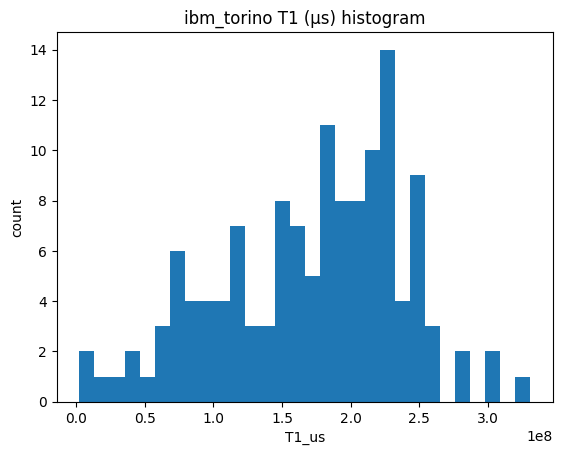

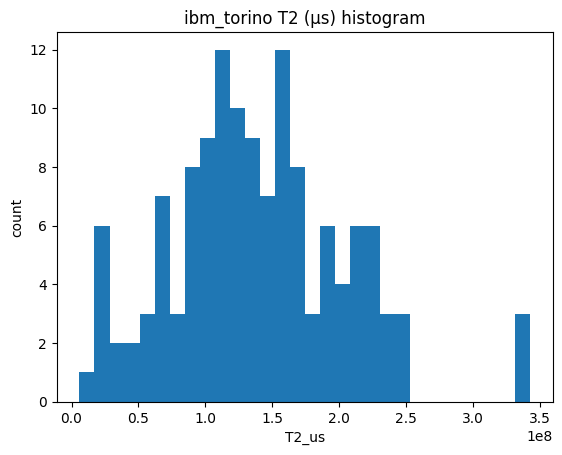

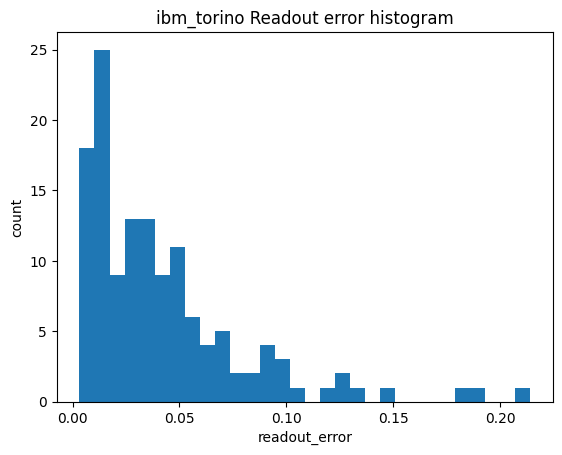

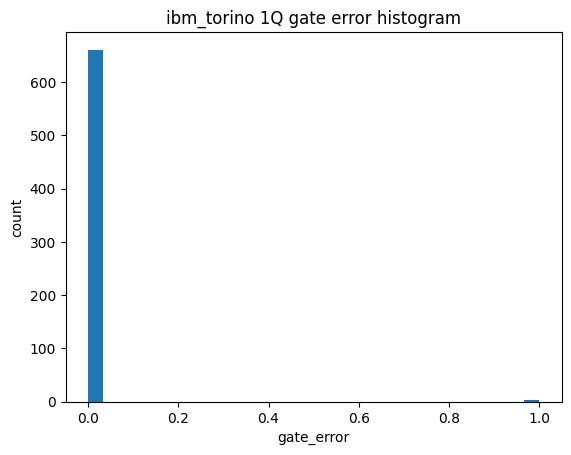

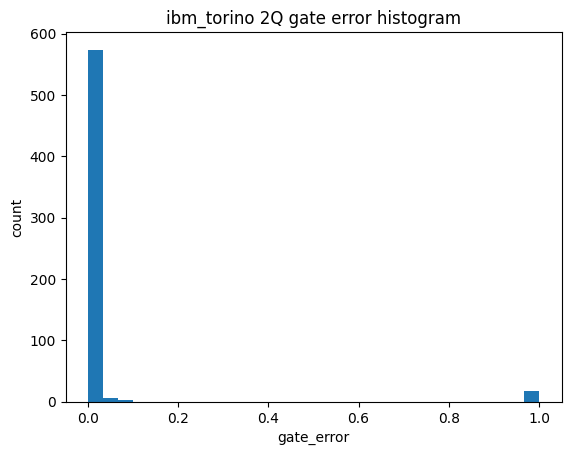

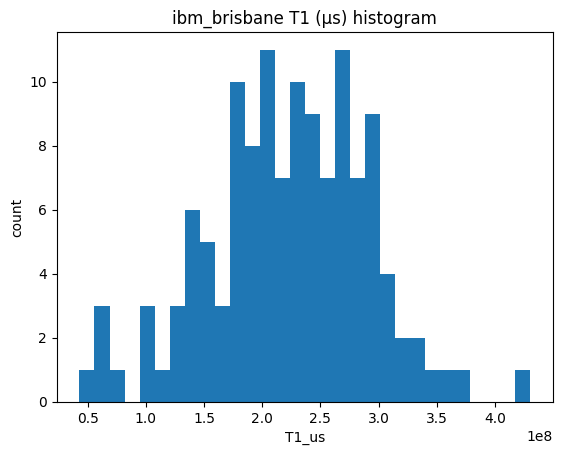

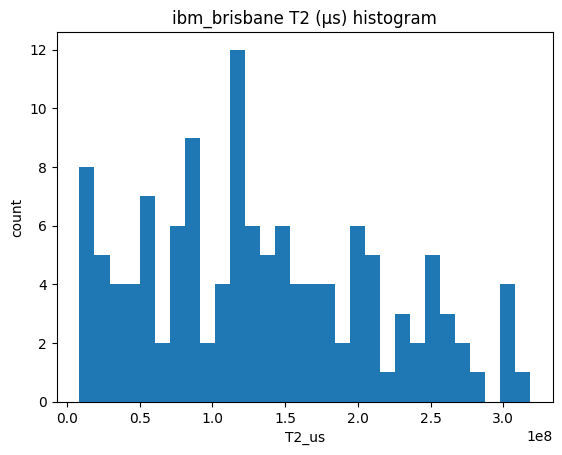

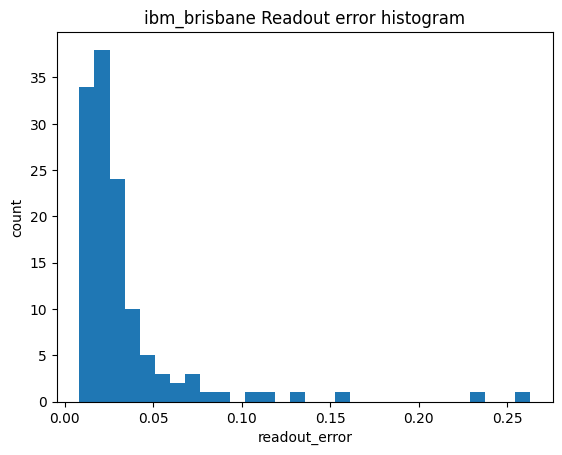

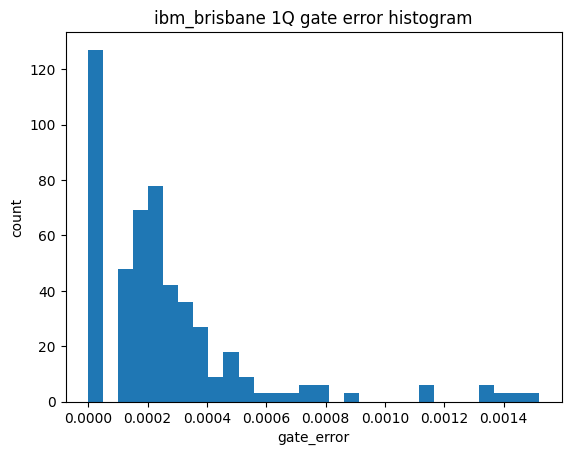

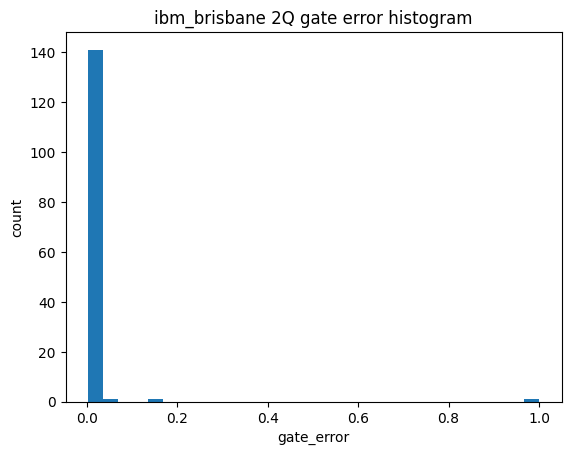

In [8]:
def plot_hist(df, column, title, outfile=None, bins=30):
    s = pd.to_numeric(df[column], errors="coerce").dropna()
    plt.figure()
    plt.hist(s, bins=bins)
    plt.xlabel(column)
    plt.ylabel("count")
    plt.title(title)
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()


for backend, bundle in [(backend_a, devA), (backend_b, devB)]:
    plot_hist(bundle["qubit_df"], "T1_us",  f"{backend.name} T1 (µs) histogram")
    plot_hist(bundle["qubit_df"], "T2_us",  f"{backend.name} T2 (µs) histogram")
    plot_hist(bundle["qubit_df"], "readout_error", f"{backend.name} Readout error histogram")
    plot_hist(bundle["oneq_df"], "gate_error", f"{backend.name} 1Q gate error histogram")
    plot_hist(bundle["twoq_df"], "gate_error", f"{backend.name} 2Q gate error histogram")

# Part 2 - GHZ scaling on ideal and two noisy simulators

In [9]:
# ----------------------- config ----------------------------------------------
N_MIN, N_MAX = 2, 20
NSHOTS = 10_000

def build_ghz(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, n)
    qc.h(0)
    for q in range(1, n):
        qc.cx(0, q)
    qc.measure(range(n), range(n))
    return qc

def ghz_theory_dist(n: int) -> dict[str, float]:
    return {"0"*n: 0.5, "1"*n: 0.5}

def probs_from_counts(counts: dict[str, int]) -> dict[str, float]:
    shots = sum(counts.values())
    if shots == 0:
        return {}
    return {k: v / shots for k, v in counts.items()}

def total_variation_distance(p: dict, q: dict) -> float:
    keys = set(p) | set(q)
    return 0.5 * sum(abs(p.get(k, 0.0) - q.get(k, 0.0)) for k in keys)

def fidelity_1_minus_tvd(p_ref: dict, q: dict) -> float:
    return 1.0 - total_variation_distance(p_ref, q)

In [10]:
ideal_sim  = AerSimulator()
noisy_sim_A = AerSimulator.from_backend(backend_a)
noisy_sim_B = AerSimulator.from_backend(backend_b) 

def run_ideal(qc: QuantumCircuit):
    tqc = transpile(qc, backend=ideal_sim, optimization_level=3)
    return ideal_sim.run(tqc, shots=NSHOTS).result().get_counts()

def run_noisy(qc: QuantumCircuit, sim: AerSimulator, map_backend):
    tqc = transpile(qc, backend=map_backend, optimization_level=3)
    return sim.run(tqc, shots=NSHOTS).result().get_counts()

In [11]:
ns = list(range(N_MIN, N_MAX + 1))
F_ideal, F_noisy_A, F_noisy_B = [], [], []

for n in tqdm(ns, desc="Running GHZ sims", unit="n"):
    qc = build_ghz(n)
    p_ref = ghz_theory_dist(n)

    p_id = probs_from_counts(run_ideal(qc))
    p_A  = probs_from_counts(run_noisy(qc, noisy_sim_A, backend_a))
    p_B  = probs_from_counts(run_noisy(qc, noisy_sim_B, backend_b))

    F_ideal.append(fidelity_1_minus_tvd(p_ref, p_id))
    F_noisy_A.append(fidelity_1_minus_tvd(p_ref, p_A))
    F_noisy_B.append(fidelity_1_minus_tvd(p_ref, p_B))

Running GHZ sims:   0%|          | 0/19 [00:00<?, ?n/s]

In [12]:
print("F_ideal =", F_ideal)
print("F_noisy_A =", F_noisy_A)
print("F_noisy_B =", F_noisy_B)

F_ideal = [0.997, 0.9936, 0.9963, 0.9967, 0.9978, 0.9945, 0.9951, 0.9994, 0.9995, 0.9951, 0.9973, 0.9937, 0.9994, 0.9915, 0.9995, 0.9941, 0.9907, 0.9951, 0.9998]
F_noisy_A = [0.9811, 0.9644, 0.9525, 0.9017999999999999, 0.8475, 0.8607, 0.8128, 0.7657, 0.7249, 0.6943, 0.6924, 0.6588, 0.675, 0.617, 0.5389999999999999, 0.5307, 0.5463, 0.5339, 0.5212]
F_noisy_B = [0.9722, 0.951, 0.9222, 0.8887, 0.8419, 0.777, 0.7892, 0.7424999999999999, 0.7142, 0.6855, 0.6831, 0.622, 0.5817, 0.5679000000000001, 0.5743, 0.49229999999999996, 0.5362, 0.45489999999999997, 0.45530000000000004]


Correlation Torino:  F vs #CX = -0.971,  F vs depth = -0.976
Correlation Brisbane: F vs #CX = -0.945,  F vs depth = -0.960


/var/folders/xc/hp0zszrs2yj02xgtw_12lrqh0000gn/T/ipykernel_77523/640575762.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, _, _ in qc.data:


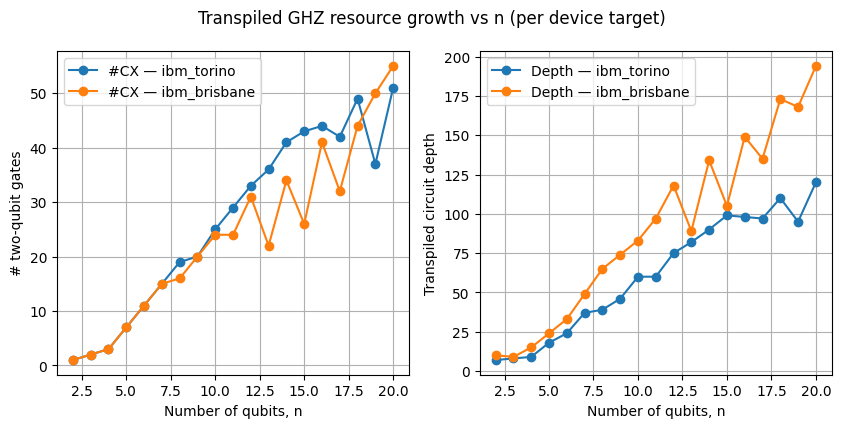

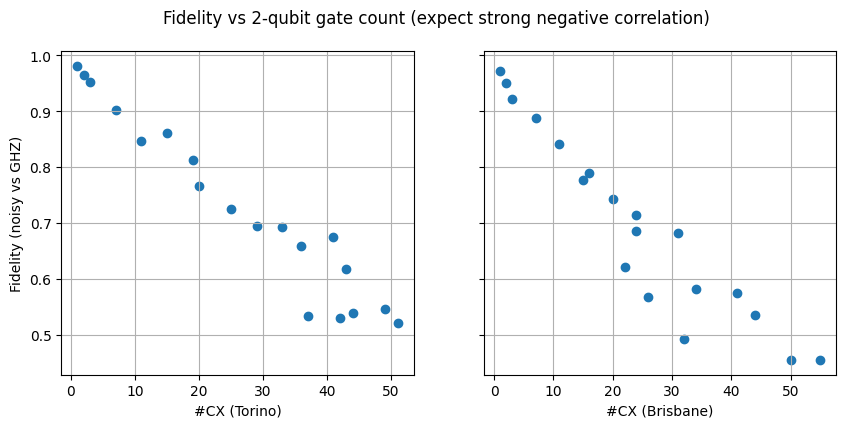

In [17]:
# --- helpers to count 2Q gates and depth to see correlation with Fidelity represented in next code block (Figure 1) ---
TWO_Q_NAMES = {"cx", "cz", "ecr", "iswap", "rxx", "ryy", "rxxplusyy", "xx_plus_yy"}

def count_two_qubit_gates(qc: QuantumCircuit) -> int:
    c = 0
    for inst, _, _ in qc.data:
        if inst.num_qubits == 2 or inst.name in TWO_Q_NAMES:
            c += 1
    return c

def transpile_family(back, opt_level=3):
    base = [build_ghz(n) for n in ns]
    return transpile(base, backend=back, optimization_level=opt_level)

tqcs_A = transpile_family(backend_a, opt_level=3)
tqcs_B = transpile_family(backend_b, opt_level=3)

cx_A   = [count_two_qubit_gates(c) for c in tqcs_A]
depth_A= [c.depth() for c in tqcs_A]
cx_B   = [count_two_qubit_gates(c) for c in tqcs_B]
depth_B= [c.depth() for c in tqcs_B]

r_A_cx    = float(np.corrcoef(F_noisy_A, cx_A)[0,1])
r_A_depth = float(np.corrcoef(F_noisy_A, depth_A)[0,1])
r_B_cx    = float(np.corrcoef(F_noisy_B, cx_B)[0,1])
r_B_depth = float(np.corrcoef(F_noisy_B, depth_B)[0,1])

print(f"Correlation Torino:  F vs #CX = {r_A_cx:.3f},  F vs depth = {r_A_depth:.3f}")
print(f"Correlation Brisbane: F vs #CX = {r_B_cx:.3f},  F vs depth = {r_B_depth:.3f}")

# --- Plot #CX and depth vs n (two panels) ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4.2), sharex=True)

axs[0].plot(ns, cx_A, marker="o", label=f"#CX — {backend_a.name}")
axs[0].plot(ns, cx_B, marker="o", label=f"#CX — {backend_b.name}")
axs[0].set_xlabel("Number of qubits, n"); axs[0].set_ylabel("# two-qubit gates"); axs[0].grid(True); axs[0].legend()

axs[1].plot(ns, depth_A, marker="o", label=f"Depth — {backend_a.name}")
axs[1].plot(ns, depth_B, marker="o", label=f"Depth — {backend_b.name}")
axs[1].set_xlabel("Number of qubits, n"); axs[1].set_ylabel("Transpiled circuit depth"); axs[1].grid(True); axs[1].legend()

fig.suptitle("Transpiled GHZ resource growth vs n (per device target)")
plt.show()

# --- Optional: scatter Fidelity vs #CX to visualize correlation ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4.2), sharey=True)
axs[0].scatter(cx_A, F_noisy_A); axs[0].set_xlabel("#CX (Torino)"); axs[0].set_ylabel("Fidelity (noisy vs GHZ)"); axs[0].grid(True)
axs[1].scatter(cx_B, F_noisy_B); axs[1].set_xlabel("#CX (Brisbane)"); axs[1].grid(True)
fig.suptitle("Fidelity vs 2-qubit gate count (expect strong negative correlation)")
plt.show()

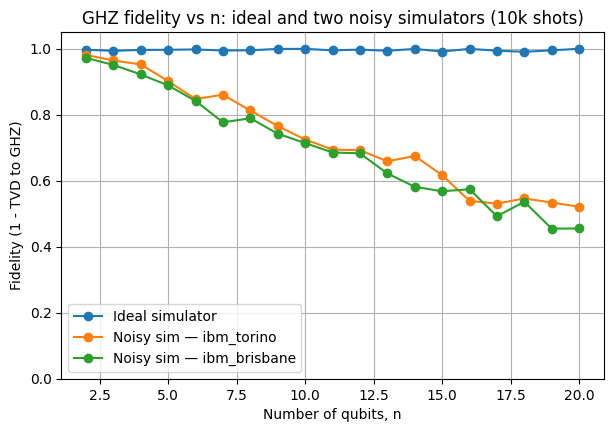

In [16]:
# ----------------------- Figure 1: Fidelity vs n ------------------------------
plt.figure(figsize=(7.0, 4.5))
plt.plot(ns, F_ideal, marker="o", label="Ideal simulator")
plt.plot(ns, F_noisy_A, marker="o", label=f"Noisy sim — {backend_a.name}")
plt.plot(ns, F_noisy_B, marker="o", label=f"Noisy sim — {backend_b.name}")
plt.ylim(0, 1.05)
plt.xlabel("Number of qubits, n")
plt.ylabel("Fidelity (1 - TVD to GHZ)")
plt.title("GHZ fidelity vs n: ideal and two noisy simulators (10k shots)")
plt.legend()
plt.grid(True)
plt.show()

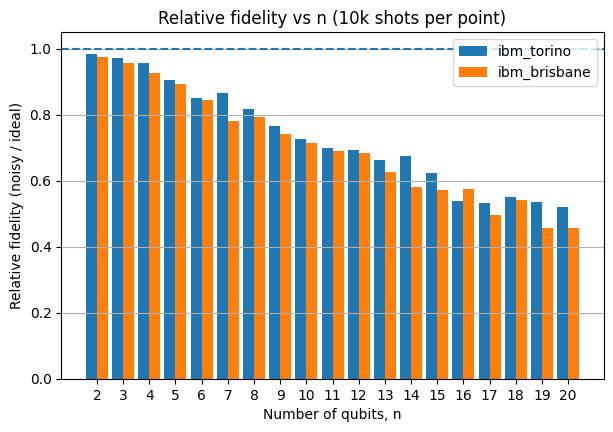

In [19]:
# ----------------------- Figure 2: Relative fidelity vs n ---------------------
# Relative fidelity R = F_noisy / F_ideal
R_A = np.array(F_noisy_A) / np.array(F_ideal)
R_B = np.array(F_noisy_B) / np.array(F_ideal)

x = np.arange(len(ns))
width = 0.42

plt.figure(figsize=(7.0, 4.5))
plt.bar(x - width/2, R_A, width, label=f"{backend_a.name}")
plt.bar(x + width/2, R_B, width, label=f"{backend_b.name}")
plt.axhline(1, linestyle="--") # chosen to indicate parity with ideal
plt.ylim(0, 1.05)
plt.xticks(x, ns)
plt.xlabel("Number of qubits, n")
plt.ylabel("Relative fidelity (noisy / ideal)")
plt.title("Relative fidelity vs n (10k shots per point)")
plt.legend()
plt.grid(axis="y")
plt.show()

# Part 3 - Fidelity at Scale

In [32]:
def compute_esp_from_collected(circuit, backend, oneq_df, twoq_df, optimization_level=3):
    """
    Compute ESP by transpiling the circuit to backend, then looking up gate errors
    in oneq_df and twoq_df (collected earlier).
    """
    tqc = transpile(circuit, backend=backend, optimization_level=optimization_level)

    esp = 1.0
    for inst, qargs, _ in tqc.data:
        name = inst.name
        if name in {"measure", "reset", "barrier", "delay", "rz"}:
            continue  # skip non-error-bearing ops

        qubits = tuple(tqc.qubits.index(q) for q in qargs)

        if len(qubits) == 1:
            q = qubits[0]
            match = oneq_df[
                (oneq_df["gate"] == name) & (oneq_df["qubit"] == q)
            ]
            if not match.empty and not np.isnan(match["gate_error"].iloc[0]):
                err = float(match["gate_error"].iloc[0])
            else:
                # fallback to mean 1q error across device
                err = float(oneq_df["gate_error"].mean(skipna=True))
        elif len(qubits) == 2:
            q0, q1 = qubits
            match = twoq_df[
                (twoq_df["gate"] == name) &
                (twoq_df["control"] == q0) &
                (twoq_df["target"] == q1)
            ]
            if match.empty:
                # try reversed order
                match = twoq_df[
                    (twoq_df["gate"] == name) &
                    (twoq_df["control"] == q1) &
                    (twoq_df["target"] == q0)
                ]
            if not match.empty and not np.isnan(match["gate_error"].iloc[0]):
                err = float(match["gate_error"].iloc[0])
            else:
                err = float(twoq_df["gate_error"].mean(skipna=True))
        else:
            continue

        esp *= (1.0 - err)

    return float(esp), tqc.depth()

In [33]:
ESP_A, ESP_B = [], []
depths_A, depths_B = [], []

for n in ns:
    ghz = build_ghz(n)
    espA, dA = compute_esp_from_collected(ghz, backend_a, devA["oneq_df"], devA["twoq_df"])
    espB, dB = compute_esp_from_collected(ghz, backend_b, devB["oneq_df"], devB["twoq_df"])
    ESP_A.append(espA); depths_A.append(dA)
    ESP_B.append(espB); depths_B.append(dB)

/var/folders/xc/hp0zszrs2yj02xgtw_12lrqh0000gn/T/ipykernel_77523/112590040.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, _ in tqc.data:


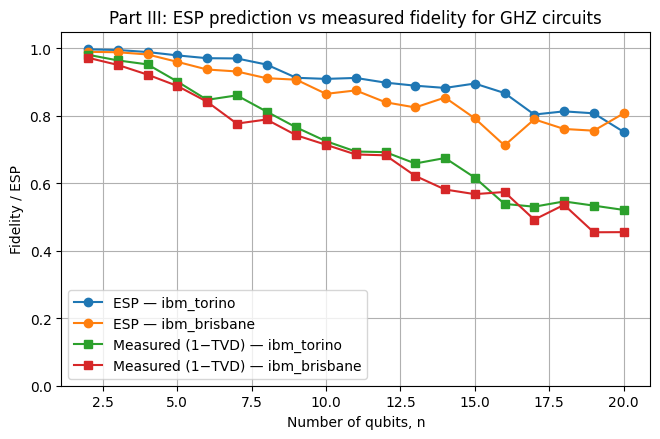

In [36]:
plt.figure(figsize=(7.6, 4.6))
plt.plot(ns, ESP_A, marker="o", label=f"ESP — {backend_a.name}")
plt.plot(ns, ESP_B, marker="o", label=f"ESP — {backend_b.name}")
plt.plot(ns, F_noisy_A, marker="s", label=f"Measured (1−TVD) — {backend_a.name}")
plt.plot(ns, F_noisy_B, marker="s", label=f"Measured (1−TVD) — {backend_b.name}")
plt.xlabel("Number of qubits, n"); plt.ylabel("Fidelity / ESP")
plt.title("Part III: ESP prediction vs measured fidelity for GHZ circuits")
plt.ylim(0, 1.05); plt.grid(True); plt.legend()
plt.show()

In [40]:
delta_A = np.array(ESP_A) - np.array(F_noisy_A)
delta_B = np.array(ESP_B) - np.array(F_noisy_B)
print(f"{backend_a.name}: mean(ESP - measured) = {np.mean(delta_A):.3f}, median = {np.median(delta_A):.3f}")
print(f"{backend_b.name}: mean(ESP - measured) = {np.mean(delta_B):.3f}, median = {np.median(delta_B):.3f}")

ibm_torino: mean(ESP - measured) = 0.178, median = 0.206
ibm_brisbane: mean(ESP - measured) = 0.170, median = 0.157
